# Analyzing the Metro de Santiago
#### First required some 

In [1]:
import requests
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import geocoder
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import matplotlib.pyplot as plt

## Getting the list of metro stations from 

In [2]:
url='https://es.wikipedia.org/wiki/Metro_de_Caracas#Lista_de_estaciones'
#url='https://es.wikipedia.org/wiki/Categor%C3%ADa:Estaciones_del_metro_de_Caracas'
# get the page info using BeautifulSoup
soup = BeautifulSoup(requests.get(url).text,'html')


In [3]:
# get the table 
tabla=soup.find('table',align="center")

In [4]:
EstM=[]
EstLink=[]

for row in tabla.findAll("a"):
    EstM.append(row.text)
    EstLink.append(row.get('href'))

#### In this case, we get the coordinates of the  metro stations from the wikipedia pages of each metro station

In [5]:
probLa=[]
probLo=[]


for link in EstLink:
    urlaux='https://es.wikipedia.org'+str(link)
    soupaux = BeautifulSoup(requests.get(urlaux).text,'html')
    tablaaux=soupaux.find("table", attrs={"class": "infobox"})
    auxLa=[]
    auxLo=[]
    try:
        for row in tablaaux.findAll("span"):
            if row.get("class")==['latitude']:
                 auxLa.append(row.text)
            if row.get("class")==['longitude']:
                 auxLo.append(row.text)
        probLa.append(auxLa[-1][:-2])
        probLo.append(auxLo[-1])
    except:
        probLa.append('NaN')
        probLo.append('NaN')


In [6]:
local=dict([(x,0) for x in ['Metro','Latitud','Longitud']])
local['Metro']=EstM
local['Latitud']=probLa
local['Longitud']=probLo
#local['Fecha']=colf
#local['Distancia']=col2

df_local=pd.DataFrame(local)
df_local.head(5)

,Metro,Latitud,Longitud
0,Propatria,10.5047,-66.9559
1,Pérez Bonalde,10.5074,-66.9479
2,Plaza Sucre,10.5138,-66.9464
3,Gato Negro,10.5157,-66.9398
4,Agua Salud,10.5133,-66.9308


In [7]:
# change the type of the columns and drop duplicate rows and Not a Number values
df_local=df_local.astype({'Latitud':'float32','Longitud':'float32','Metro':'string'})
df_local.dropna(inplace=True)
df_local.drop_duplicates(subset=['Metro'], inplace=True)
df_local.reset_index(drop=True, inplace=True)

In [8]:
df_local.dtypes

Metro        string
Latitud     float32
Longitud    float32
dtype: object

#### Coordinates for Caracas

In [10]:
address = 'Caracas, VE'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Caracas are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Caracas are 10.506098, -66.9146017.


### In the Map

In [11]:
map_CCS = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for latitud, longitud, zona in zip(df_local['Latitud'], df_local['Longitud'], df_local['Metro']):
    label = '{}'.format(zona)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitud, longitud],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CCS)  
    
map_CCS


## My credentials to use Foursquareare API

In [13]:
CLIENT_ID = 'L31KL3NI05XESARMV25LFRTNJMHJIPEZ0NPFBTMQMMXHMTWR' # your Foursquare ID
CLIENT_SECRET = 'OUATITFZ4JMKXTJ3JWNRBDUPWPFUTI4RZJNNHBGVV2CEXA1B' # your Foursquare Secret
VERSION = '20180605' # Foursquare version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: L31KL3NI05XESARMV25LFRTNJMHJIPEZ0NPFBTMQMMXHMTWR
CLIENT_SECRET:OUATITFZ4JMKXTJ3JWNRBDUPWPFUTI4RZJNNHBGVV2CEXA1B


In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=260):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro', 
                  'Metro Latitude', 
                  'Metro Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
CCS_venues = getNearbyVenues(names=df_local['Metro'],
                                   latitudes=df_local['Latitud'],
                                   longitudes=df_local['Longitud']
                                  )

Propatria
Pérez Bonalde
Plaza Sucre
Gato Negro
Agua Salud
Caño Amarillo
Capitolio
La Hoyada
Parque Carabobo
Bellas Artes
Colegio de Ingenieros
Plaza Venezuela
Sabana Grande
Chacaíto
Chacao
Altamira
Miranda
Los Dos Caminos
Los Cortijos
La California
Petare
Palo Verde
El Silencio
Capuchinos
Maternidad
Artigas
La Paz
La Yaguara
Carapita
Antímano
Mamera
Caricuao
Zoológico
Ruiz Pineda
/ Las Adjuntas
Ciudad Universitaria
Los Símbolos
La Bandera
El Valle
Los Jardines
Coche
Mercado
La Rinconada
Teatros
Nuevo Circo
Parque Central
Zona Rental
Bello Monte


In [17]:
print(CCS_venues.shape)
CCS_venues.head()

(358, 7)


,Metro,Metro Latitude,Metro Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Propatria,10.5047,-66.955902,Tequechongos Centro comercial Propatria,10.502533,-66.955522,Fast Food Restaurant
1,Pérez Bonalde,10.5074,-66.947899,Estación de Transferencia Zona Rental,10.507944,-66.947850,Metro Station
2,Pérez Bonalde,10.5074,-66.947899,Doctor Caucho,10.508673,-66.949567,Convenience Store
3,Plaza Sucre,10.5138,-66.946404,Piñateria La Mejor De Catia,10.513836,-66.946024,Toy / Game Store
4,Plaza Sucre,10.5138,-66.946404,El Arabito,10.513380,-66.945048,African Restaurant


In [145]:
barra=CCS_venues.groupby('Metro').count()
barra


,Metro Latitude,Metro Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Metro,,,,,,
/ Las Adjuntas,4,4,4,4,4,4
Agua Salud,5,5,5,5,5,5
Altamira,27,27,27,27,27,27
Antímano,4,4,4,4,4,4
Artigas,6,6,6,6,6,6
Bellas Artes,11,11,11,11,11,11
Bello Monte,7,7,7,7,7,7
Capitolio,11,11,11,11,11,11
Capuchinos,2,2,2,2,2,2


In [167]:
graph=barra['Venue']

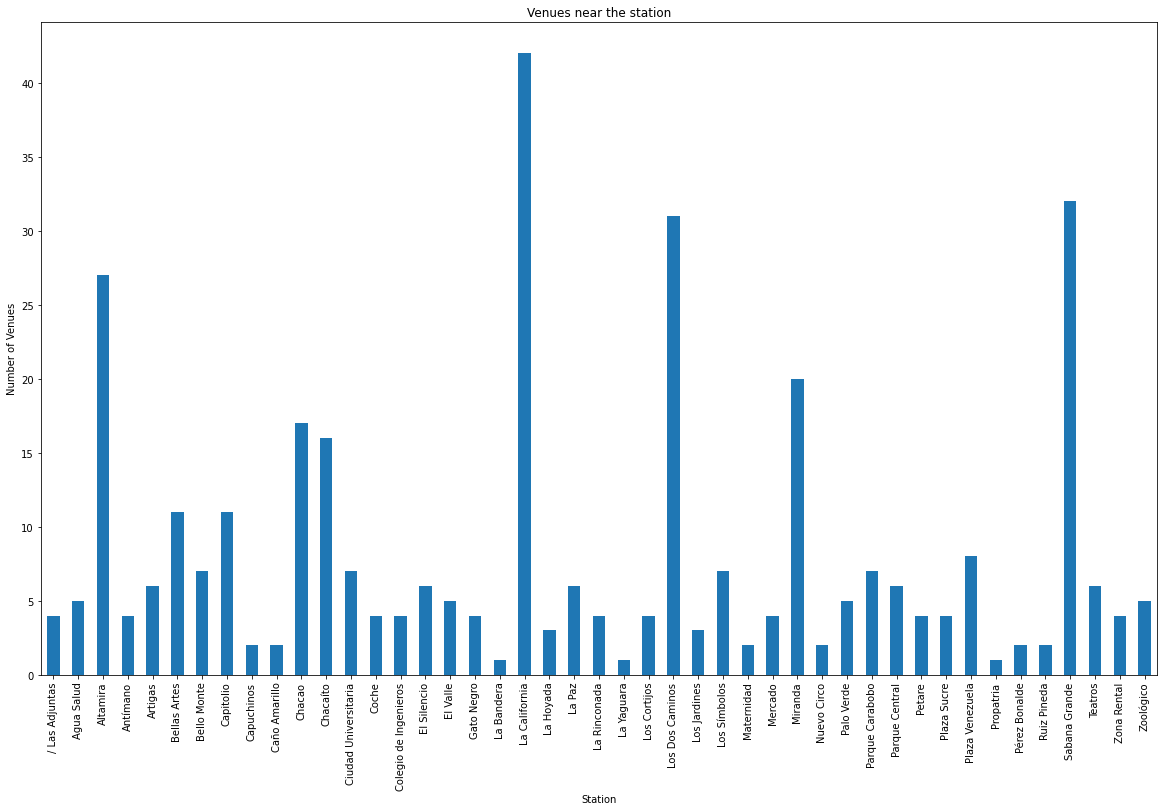

In [147]:
barra['Venue'].plot(kind='bar', figsize=(20, 12))

plt.xlabel('Station') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venues near the station') # add title to the plot

plt.show()

In [148]:
barra['Venue'].describe()

count    45.000000
mean      7.955556
std       9.017547
min       1.000000
25%       4.000000
50%       5.000000
75%       7.000000
max      42.000000
Name: Venue, dtype: float64

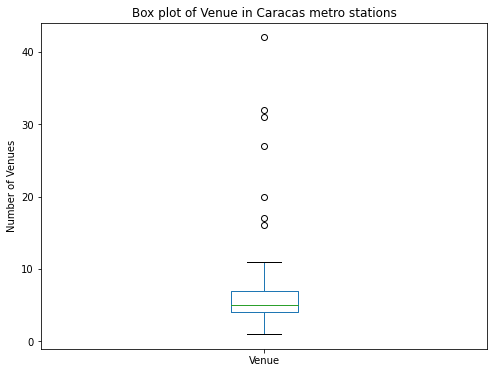

In [163]:
barra['Venue'].plot(kind='box', figsize=(8, 6))

plt.title('Box plot of Venue in Caracas metro stations')
plt.ylabel('Number of Venues')

plt.show()

In [168]:
out=barra['Venue'].describe()[6]+(barra['Venue'].describe()[6]-barra['Venue'].describe()[4])*1.5

In [169]:
graph=graph.reset_index()
print(out)
graph

11.5


,Metro,Venue
0,/ Las Adjuntas,4
1,Agua Salud,5
2,Altamira,27
3,Antímano,4
4,Artigas,6
5,Bellas Artes,11
6,Bello Monte,7
7,Capitolio,11
8,Capuchinos,2
9,Caño Amarillo,2


In [170]:
outliners=graph[graph['Venue']>out]
outliners

,Metro,Venue
2,Altamira,27
10,Chacao,17
11,Chacaíto,16
19,La California,42
25,Los Dos Caminos,31
30,Miranda,20
41,Sabana Grande,32


In [154]:
outloc=df_local[df_local['Metro'].isin(outliners['Metro'])].drop_duplicates(subset=['Metro'])
outloc

,Metro,Latitud,Longitud
12,Sabana Grande,10.492900,-66.875702
13,Chacaíto,10.490500,-66.868797
14,Chacao,10.491900,-66.855698
15,Altamira,10.495566,-66.848892
16,Miranda,10.497300,-66.841400
17,Los Dos Caminos,10.494800,-66.833397
19,La California,10.484400,-66.819901


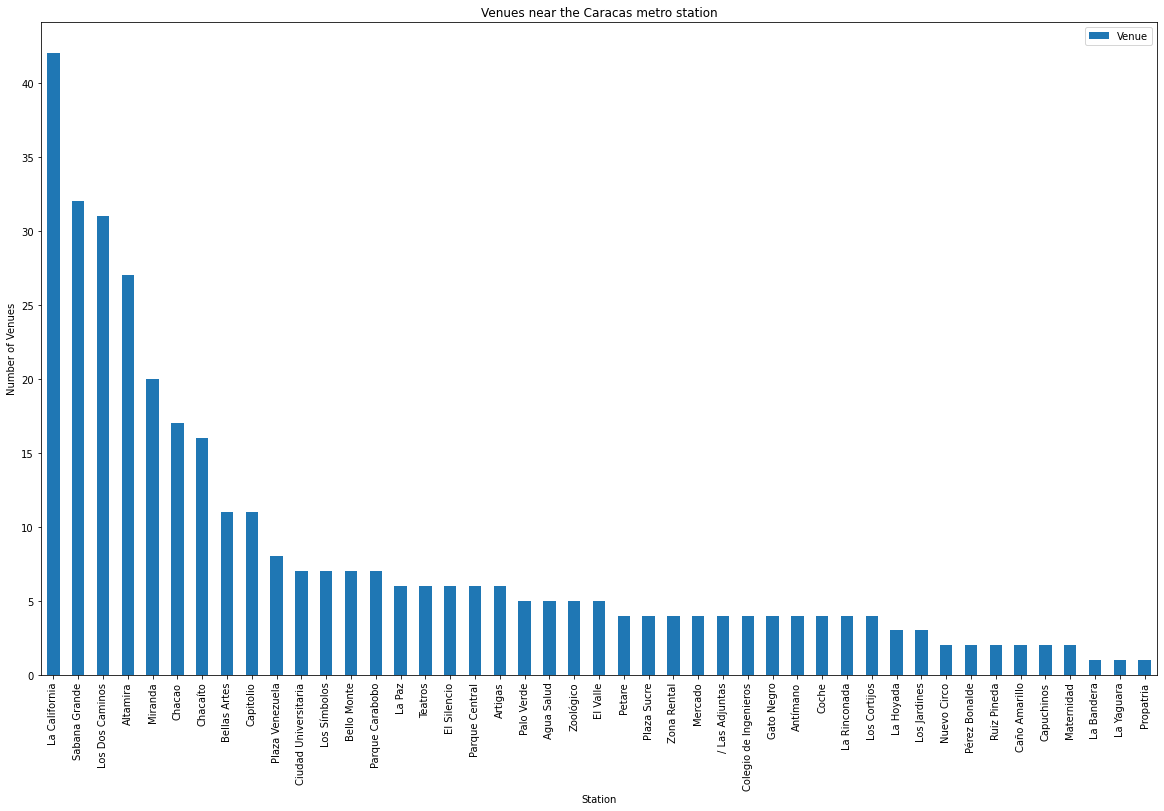

In [162]:
graph_sort=graph.sort_values(['Venue'], ascending=False, axis=0)#, inplace=True)


graph_sort.set_index('Metro').plot(kind='bar', figsize=(20, 12))

plt.xlabel('Station') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venues near the Caracas metro station') # add title to the plot

plt.show()

In [156]:
map_STGO = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for latitud, longitud, zona in zip(outloc['Latitud'], outloc['Longitud'], outloc['Metro']):
    label = '{}'.format(zona)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitud, longitud],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_STGO)  
    
map_STGO

In [157]:
outloc.count()

Metro       7
Latitud     7
Longitud    7
dtype: int64

In [19]:
print('There are {} uniques categories.'.format(len(CCS_venues['Venue Category'].unique())))

There are 101 uniques categories.


##  Analyze Each Metro Station

In [20]:
# one hot encoding
CCS_onehot = pd.get_dummies(CCS_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
CCS_onehot['Metro'] = CCS_venues['Metro'] 

# move neighborhood column to the first column
fixed_columns = [CCS_onehot.columns[-1]] + list(CCS_onehot.columns[:-1])
CCS_onehot = CCS_onehot[fixed_columns]

CCS_onehot.head()

,Metro,African Restaurant,American Restaurant,Arepa Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,...,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Volleyball Court,Wings Joint,Yoga Studio
0,Propatria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pérez Bonalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Pérez Bonalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Plaza Sucre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Plaza Sucre,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
CCS_grouped = CCS_onehot.groupby('Metro').mean().reset_index()
CCS_grouped

,Metro,African Restaurant,American Restaurant,Arepa Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,...,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Volleyball Court,Wings Joint,Yoga Studio
0,/ Las Adjuntas,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
1,Agua Salud,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.400000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
2,Altamira,0.00,0.000000,0.074074,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.037037,0.00
3,Antímano,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
4,Artigas,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.166667,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
5,Bellas Artes,0.00,0.000000,0.000000,0.000000,0.090909,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
6,Bello Monte,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.142857,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
7,Capitolio,0.00,0.090909,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
8,Capuchinos,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.500000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00
9,Caño Amarillo,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00


In [23]:
CCS_grouped.shape

(45, 102)

In [24]:
num_top_venues = 5

for hood in CCS_grouped['Metro']:
    print("----"+hood+"----")
    temp = CCS_grouped[CCS_grouped['Metro'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----/ Las Adjuntas----
                  venue  freq
0         Metro Station  0.75
1            Restaurant  0.25
2    African Restaurant  0.00
3  Other Great Outdoors  0.00
4           Music Venue  0.00


----Agua Salud----
                 venue  freq
0               Bakery   0.4
1        Metro Station   0.2
2        Shopping Mall   0.2
3  Fried Chicken Joint   0.2
4   African Restaurant   0.0


----Altamira----
                venue  freq
0         Coffee Shop  0.11
1  Chinese Restaurant  0.11
2  Falafel Restaurant  0.07
3    Arepa Restaurant  0.07
4         Pizza Place  0.07


----Antímano----
                  venue  freq
0         Metro Station  0.25
1  Fast Food Restaurant  0.25
2                Garden  0.25
3        Sandwich Place  0.25
4  Other Great Outdoors  0.00


----Artigas----
                  venue  freq
0         Shopping Mall  0.33
1         Metro Station  0.17
2                Bakery  0.17
3  Fast Food Restaurant  0.17
4              Pharmacy  0.17


----Bellas Artes

4  Metro Station  0.00


----Zona Rental----
                       venue  freq
0  South American Restaurant  0.25
1  Latin American Restaurant  0.25
2        Fried Chicken Joint  0.25
3       Fast Food Restaurant  0.25
4         African Restaurant  0.00


----Zoológico----
           venue  freq
0       Pharmacy   0.2
1  Metro Station   0.2
2            Gym   0.2
3  Shopping Mall   0.2
4     Skate Park   0.2




In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Metro']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Metro'] = CCS_grouped['Metro']

for ind in np.arange(CCS_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CCS_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Metro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,/ Las Adjuntas,Metro Station,Restaurant,Yoga Studio,Coffee Shop,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop
1,Agua Salud,Bakery,Fried Chicken Joint,Metro Station,Shopping Mall,Yoga Studio,Falafel Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Department Store
2,Altamira,Coffee Shop,Chinese Restaurant,Arepa Restaurant,Pizza Place,Plaza,Falafel Restaurant,Gastropub,Breakfast Spot,Gay Bar,Pub
3,Antímano,Garden,Sandwich Place,Fast Food Restaurant,Metro Station,Yoga Studio,Electronics Store,College Quad,Concert Hall,Convenience Store,Cupcake Shop
4,Artigas,Shopping Mall,Pharmacy,Bakery,Metro Station,Fast Food Restaurant,Yoga Studio,Concert Hall,Convenience Store,Cupcake Shop,Department Store


## Clustering

In [27]:
#Selecting the value for k the clustering

Sum_of_squared_distances = []
CCS_grouped_clustering = CCS_grouped.drop('Metro', 1)
K = range(1,44)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(CCS_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

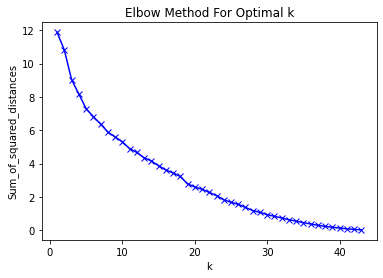

In [28]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### There is no a clear elbow, so it is necessary use the silhouette method


In [29]:
sil = []
K = range(2,44)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in K:
  km1 = KMeans(n_clusters=k, random_state=0).fit(CCS_grouped_clustering)
  labels = km1.labels_
  sil.append(silhouette_score(CCS_grouped_clustering, labels, metric = 'euclidean'))

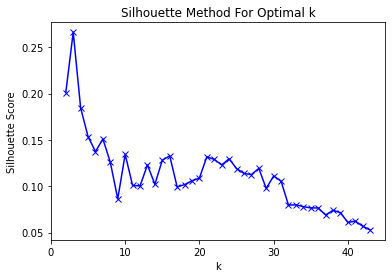

In [30]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

#### Select the second maximun value k=3

In [31]:
# set number of clusters

kclusters = 3

CCS_grouped_clustering = CCS_grouped.drop('Metro', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CCS_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_, allow_duplicates = False)

CCS_merged = df_local

# merge CCS_grouped with df_local to add latitude/longitude for each neighborhood
CCS_merged = CCS_merged.join(neighborhoods_venues_sorted.set_index('Metro'), on='Metro')

CCS_merged.head() # check the last columns!

,Metro,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Propatria,10.5047,-66.955902,0.0,Fast Food Restaurant,Farmers Market,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop
1,Pérez Bonalde,10.5074,-66.947899,1.0,Convenience Store,Metro Station,Yoga Studio,Farmers Market,Concert Hall,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop
2,Plaza Sucre,10.5138,-66.946404,2.0,African Restaurant,Pharmacy,Toy / Game Store,Dessert Shop,Falafel Restaurant,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store
3,Gato Negro,10.5157,-66.939796,2.0,Bus Station,Park,Metro Station,Coffee Shop,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop
4,Agua Salud,10.5133,-66.930801,2.0,Bakery,Fried Chicken Joint,Metro Station,Shopping Mall,Yoga Studio,Falafel Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Department Store


In [33]:
CCS_merged.loc[CCS_merged['Cluster Labels'].isna(),'Cluster Labels']=3.0

In [34]:
CCS_merged=CCS_merged.astype({'Cluster Labels':'int32'})

In [36]:
# Percentage of stations in each cluster
CCS_merged.groupby('Cluster Labels').count()/CCS_merged.shape[0]*100

,Metro,Latitud,Longitud,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
0,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667,4.166667
1,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000,6.250000
2,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333
3,6.250000,6.250000,6.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [179]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for Latitude, Longitude, poi, cluster in zip(CCS_merged['Latitud'], CCS_merged['Longitud'], CCS_merged['Metro'], CCS_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [172]:
CCS_merged.loc[CCS_merged['Cluster Labels'] == 0, CCS_merged.columns[[0] + list(range(4, CCS_merged.shape[1]))]]

,Metro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Propatria,Fast Food Restaurant,Farmers Market,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop
27,La Yaguara,Fast Food Restaurant,Farmers Market,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop


In [173]:
CCS_merged.loc[CCS_merged['Cluster Labels'] == 1, CCS_merged.columns[[0] + list(range(4, CCS_merged.shape[1]))]]

,Metro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Pérez Bonalde,Convenience Store,Metro Station,Yoga Studio,Farmers Market,Concert Hall,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop
5,Caño Amarillo,Brewery,Metro Station,College Cafeteria,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Diner,Donut Shop
34,/ Las Adjuntas,Metro Station,Restaurant,Yoga Studio,Coffee Shop,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop


In [174]:
CCS_merged.loc[CCS_merged['Cluster Labels'] == 2, CCS_merged.columns[[0] + list(range(4, CCS_merged.shape[1]))]]

,Metro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Plaza Sucre,African Restaurant,Pharmacy,Toy / Game Store,Dessert Shop,Falafel Restaurant,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store
3,Gato Negro,Bus Station,Park,Metro Station,Coffee Shop,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop
4,Agua Salud,Bakery,Fried Chicken Joint,Metro Station,Shopping Mall,Yoga Studio,Falafel Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Department Store
6,Capitolio,Pharmacy,Electronics Store,American Restaurant,Multiplex,Plaza,Café,Fast Food Restaurant,Bus Station,Sandwich Place,Diner
7,La Hoyada,American Restaurant,Pharmacy,Middle Eastern Restaurant,Yoga Studio,Falafel Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Department Store,Dessert Shop
8,Parque Carabobo,Pharmacy,Pizza Place,Bakery,Restaurant,Spanish Restaurant,Fast Food Restaurant,Metro Station,Yoga Studio,Donut Shop,College Quad
9,Bellas Artes,Italian Restaurant,Museum,Fried Chicken Joint,Fast Food Restaurant,Sports Bar,Pharmacy,Pizza Place,Asian Restaurant,Gym,Lounge
10,Colegio de Ingenieros,Gym / Fitness Center,Concert Hall,Candy Store,Bus Line,College Quad,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Diner
11,Plaza Venezuela,Fried Chicken Joint,South American Restaurant,Hotel,Department Store,Food & Drink Shop,Fast Food Restaurant,Coffee Shop,Electronics Store,College Quad,Concert Hall
12,Sabana Grande,Italian Restaurant,Spanish Restaurant,Gym,Bakery,Café,Fast Food Restaurant,Other Great Outdoors,Burger Joint,Coffee Shop,Mediterranean Restaurant


In [175]:
CCS_merged.loc[CCS_merged['Cluster Labels'] == 3, CCS_merged.columns[[0] + list(range(4, CCS_merged.shape[1]))]]

,Metro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Carapita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Mamera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Caricuao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
#CCS_merged['1st Most Common Venue'].str.match('^.*Fast*')
#CCS_merged[CCS_merged['1st Most Common Venue'].str.match('^.*Art*')==True]
#CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].any.str.contains('^.*Art*')
#CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].str.eq('Fast').any(1)

#CCS_merged[CCS_merged.apply(lambda row: row.astype(str).str.contains('Fast').any(), axis=1)]

CCS_merged[CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].apply(lambda row: row.astype(str).str.contains('Hotel').any(), axis=1)][['Metro','Cluster Labels']]


,Metro,Cluster Labels
11,Plaza Venezuela,2
16,Miranda,2


In [139]:
CCS_resto=CCS_merged[CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].apply(lambda row: row.astype(str).str.contains('Restaurant').any(), axis=1)][['Metro','Cluster Labels','Longitud','Latitud']]
CCS_mus=CCS_merged[CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].apply(lambda row: row.astype(str).str.contains('Museum').any(), axis=1)][['Metro','Cluster Labels','Longitud','Latitud']]
CCS_art=CCS_merged[CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].apply(lambda row: row.astype(str).str.contains('Art').any(), axis=1)][['Metro','Cluster Labels','Longitud','Latitud']]
CCS_hot=CCS_merged[CCS_merged[CCS_merged.columns[list(range(4, CCS_merged.shape[1]))]].apply(lambda row: row.astype(str).str.contains('Hotel').any(), axis=1)][['Metro','Cluster Labels','Longitud','Latitud']]

In [140]:
CCS_int=CCS_art.append(CCS_mus)
CCS_int.drop_duplicates(subset=['Metro'], inplace=True)
CCS_int

,Metro,Cluster Labels,Longitud,Latitud
44,Nuevo Circo,2,-66.908890,10.50000
45,Parque Central,2,-66.901649,10.49785
9,Bellas Artes,2,-66.900703,10.50070


In [141]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for Latitude, Longitude, poi, cluster in zip(CCS_resto['Latitud'], CCS_resto['Longitud'], CCS_resto['Metro'], CCS_resto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for Latitude, Longitude, poi, cluster in zip(CCS_int['Latitud'], CCS_int['Longitud'], CCS_int['Metro'], CCS_int['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [177]:
outclu=CCS_merged[CCS_merged['Metro'].isin(outliners['Metro'])].drop_duplicates(subset=['Metro'])
outclu[CCS_merged.columns[[0] + list(range(3, CCS_merged.shape[1]))]]

,Metro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Sabana Grande,2,Italian Restaurant,Spanish Restaurant,Gym,Bakery,Café,Fast Food Restaurant,Other Great Outdoors,Burger Joint,Coffee Shop,Mediterranean Restaurant
13,Chacaíto,2,Italian Restaurant,Gym,Cupcake Shop,Department Store,Mobile Phone Shop,Chinese Restaurant,Café,Bus Station,Sandwich Place,Breakfast Spot
14,Chacao,2,Sandwich Place,Business Service,Café,Cajun / Creole Restaurant,Mediterranean Restaurant,Pizza Place,Japanese Restaurant,Pharmacy,Fast Food Restaurant,Gastropub
15,Altamira,2,Coffee Shop,Chinese Restaurant,Arepa Restaurant,Pizza Place,Plaza,Falafel Restaurant,Gastropub,Breakfast Spot,Gay Bar,Pub
16,Miranda,2,Sandwich Place,Café,Yoga Studio,Gym,Hotel,Hotel Bar,Falafel Restaurant,Latin American Restaurant,Donut Shop,Concert Hall
17,Los Dos Caminos,2,Fast Food Restaurant,Electronics Store,Pizza Place,Café,Sushi Restaurant,Sandwich Place,Ice Cream Shop,Clothing Store,Shopping Mall,Cupcake Shop
19,La California,2,Ice Cream Shop,Fast Food Restaurant,Italian Restaurant,Clothing Store,Coffee Shop,Sandwich Place,Seafood Restaurant,Café,Pharmacy,Pizza Place


In [178]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for Latitude, Longitude, poi, cluster in zip(outclu['Latitud'], outclu['Longitud'], outclu['Metro'], outclu['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
14*16